# Barrido de soluciones del modelo de Fourier (gráficas de línea)
# $$\dfrac{\partial T}{\partial t} = \alpha \dfrac{\partial}{\partial x}\left[ D \dfrac{\partial T}{\partial x} \right] + \beta \dfrac{\partial T}{\partial x} + \varsigma$$ 

# $$q = - k \dfrac{\partial T}{\partial x}$$

La ecuación de transporte esta dada en su forma adimensional por medio de las siguientes variables adimensionales y parámetros:
* $T$ es la temperatura
* $t$ es el tiempo
* $x$ es la dirección espacial x
* $q$ es el flujo de calor
* $D$ es la difusividad térmica $D = k c^{-1}$
* Con $k$ la conductividad térmica y $c$ el producto de la densidad $\rho$ con la capacidad calofífica a volumen constante $C_v$
* El parámetro $\alpha$ es el número de Fourier $\alpha = D_0 t_0 L^{-2}$
* Con $t_0$ es el tiempo carácterisco, $D_0$ es la difusividad térmica de referencia del material y $L$ es la longitud del material
* El parámetro $\beta$ esta definido por $\beta = \alpha D \tfrac{\partial}{\partial x} \left[ \log (c) \right]$
* El parámetro $\varsigma$ es la interacción del sistema con el ambiente

Este problema en particular se va a resolver para dos casos a las condiciones de frontera:
* Caso 1: $T(0, t) = 1 + A (\sin(\omega_i t) + 1) \quad$ y $\quad T(1, t) = 1$
* Caso 2: $T(0, t) = 1 \quad$ y $\quad T(1, t) = 1 + A (\sin(\omega_i t) + 1)$

Donde se hace el barrido de frecuencias $\omega_i \in [\omega_0, \omega_n]$. 

Ambos casos con la condición inicial
* $T(x, 0) = 1$


## Importación de bibliotecas
Estas bibliotecas son las necesarias para llevar a cabo la simulación

In [1]:
from IPython import display
import ipywidgets                # Barra de progreso
import numpy as np               # Cálculos numéricos basados en los arreglos numpy
import matplotlib.pyplot as plt  # Graficación
import scienceplots              # Estilos de graficacion
import seaborn as sns
from numba import jit            # Incrementa la velocidad de la simulación
from scipy import integrate      # Modulo de integracion
import modulo_fourier as mf      # Módulo que contiene las derivadas y el solver

## Opciones de graficación
Estética de las gráficas

In [2]:
sns.set_context("paper", font_scale = 1.5)
plt.style.use(["science", "grid"])

## Simulación
Función de Python que realiza la simulación numérica para cada frecuencia. A continuación se tiene el pseudo-código:
1. Generar la frontera oscilatoria dado el valor de la frecuencia (y amplitud).
2. Inicializar el arreglo de la solucion para la temperatura (condiciones iniciales)
3. Aplicar las condiciones de frontera fijas, posteriormente en el loop for se actualizan las oscilantes
4. Inicializar las series de tiempo del flujo de calor, aquí se registra el flujo de calor de la pared fija
5. Usando diferencias finitas en el espacio y Runge-Kutta en el tiempo, se realiza la simulación. 
   Durante la simulación, se construyen las series de tiempo del flujo de calor
6. Se devuelve la serie de tiempo del flujo de calor

In [3]:
@jit(nopython = True)
def simulacion(amplitud, frecuencia, interaccion, valfa, vbeta, dif, con, tiempo, nt, nx, dt, dx):
    # Generación de la frontera oscilatoria
    frontera = 1 + amplitud * (np.sin(frecuencia * tiempo) + 1)
    # Condición inicial
    sol1_temperatura = np.linspace(frontera[0], 1, nx + 1)
    sol2_temperatura = np.linspace(1, frontera[0], nx + 1)
    # Inicializacion de las series de tiempo del flujo de calor
    series1_flujocalor = np.zeros(nt + 1)
    series2_flujocalor = np.zeros(nt + 1)
    # Simulacion
    for n in range(nt + 1):
        # Actualización de la frontera oscilatoria
        sol1_temperatura[0] = frontera[n]
        sol2_temperatura[-1] = frontera[n]
        # Calculo de la Temperatura
        sol1_temperatura = mf.rungekutta(sol1_temperatura, interaccion, valfa, vbeta, dif, dx, dt)
        sol2_temperatura = mf.rungekutta(sol2_temperatura, interaccion, valfa, vbeta, dif, dx, dt)
        # Calculo del flujo de calor
        grad1_temperatura = mf.ddx(sol1_temperatura, dx, full = True)
        grad2_temperatura = mf.ddx(sol2_temperatura, dx, full = True)
        sol1_flujocalor = mf.calc_q(con, grad1_temperatura)
        sol2_flujocalor = mf.calc_q(con, grad2_temperatura) 
        # Captura de los valores para la serie de tiempo, en la pared fija
        series1_flujocalor[n] = sol1_flujocalor[-1]
        series2_flujocalor[n] = sol2_flujocalor[0]
    #Devolver las series del flujo de calor del caso 1 y caso 2
    return series1_flujocalor, series2_flujocalor

## Dominio espacial

La solución numérica del problema se presenta solo en una dimensión espacial

In [4]:
nx = 256                        # Numero de pasos en el espacio
Lx = 1.0                        # Longitud del dominio espacial
x = np.linspace(0, Lx, nx + 1)  # Vector del dominio espacial, contiene nx+1 puntos incluyendo el 0
dx = x[1] - x[0]                # Tamaño de paso en el espacio
dx

0.00390625

## Dominio temporal

El tiempo que se pretende dar solución al sistema de ecuaciones

In [5]:
nt = 2_000_000                  # Numero de pasos en el tiempo
Lt = 20.0                       # Longitud del dominio temporal
t = np.linspace(0, Lt, nt + 1)  # Vector del dominio temporal, contiene nt+1 puntos incluyendo el 0
dt = t[1] - t[0]                # Tamaño de paso en el tiempo
dt

1e-05

## Construcción del material

### Exponentes

In [6]:
nexp = 4
exponente = np.linspace(1.0, 10.0, num = nexp)

### Concentración

In [7]:
concentracion = np.empty((nexp, nx + 1))
for e in range(nexp):
    concentracion[e] = 1 - x ** exponente[e]

### Gráfica de la concentración

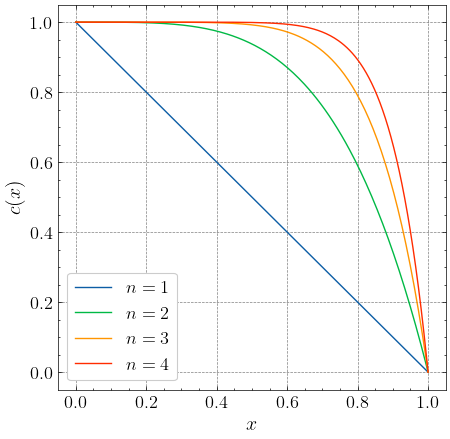

In [8]:
plt.figure(figsize = (5, 5))
plt.xlabel("$x$")
plt.ylabel("$c(x)$")
for e in range(nexp):
    plt.plot(x, concentracion[e], label = f"$n = {e + 1}$")
plt.legend(loc = "best")
plt.savefig("graficas/concentracion_material.pdf", dpi = 300, bbox_inches = "tight")
plt.show()

### Densidad, Capacidad Calorífica y Conductividad Térmica base del Si y Ge

In [9]:
# Densidad
densidad_si = 2330.0
densidad_ge = 5322.0
# Capacidad Calorífica
cap_calor_si = 710.0
cap_calor_ge = 320.0
# Conductividad Térmica
conductividad_si = 43.58
conductividad_ge = 23.50

### Densidad y Capacidad Calorífica dimensional sobre todo el material

In [10]:
densidad_dim = densidad_ge + (densidad_si - densidad_ge) * concentracion
cap_calor_dim = cap_calor_ge + (cap_calor_si - cap_calor_ge) * concentracion

### Coeficientes del polinomio

In [11]:
coef_a = 1.348
coef_b = 6.38
coef_d = -5.363 
coef_e = 22.145
coef_f = 252.53
coef_g = -251.94

In [12]:
conductividad_dummy = (
    coef_a * np.exp(coef_b + coef_d) +
    coef_e * np.exp(coef_f + coef_g)
)

conductividad_dummy

43.67639200657393

### Conductividad Térmica dimensional sobre todo el material (polinomio)

In [13]:
conductividad_dim = (
    coef_a * np.exp(concentracion * (coef_d + (coef_b * concentracion))) +
    coef_e * np.exp(concentracion * (coef_g + (coef_f * concentracion)))
)

difusividad_dim = conductividad_dim / (densidad_dim * cap_calor_dim)

### Densidad, Capacidad Calorífica, Conductividad Térmica y Difusividad Térmica adimensional

In [14]:
densidad = densidad_dim / densidad_si
cap_calor = cap_calor_dim / cap_calor_si
conductividad = conductividad_dim / conductividad_si
difusividad = conductividad / (densidad * cap_calor)

### Gráfica de la Densidad

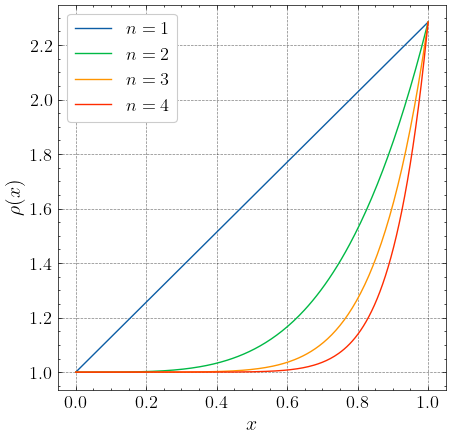

In [15]:
plt.figure(figsize = (5, 5))
plt.xlabel("$x$")
plt.ylabel("$\\rho (x)$")
for e in range(nexp):
    plt.plot(x, densidad[e], label = f"$n = {e + 1}$")
plt.legend(loc = "best")
plt.savefig("graficas/densidad_material.pdf", dpi = 300, bbox_inches = "tight")
plt.show()

### Gráfica de la Capacidad Calorífica

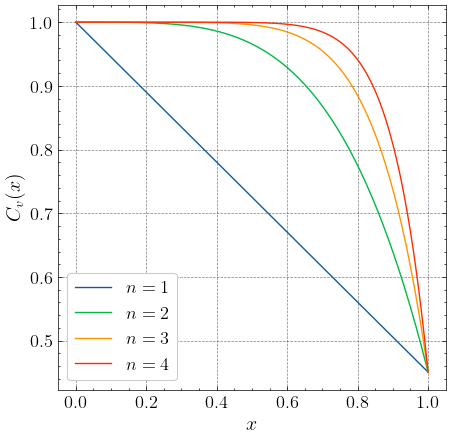

In [16]:
plt.figure(figsize = (5, 5))
plt.xlabel("$x$")
plt.ylabel("$C_v(x)$")
for e in range(nexp):
    plt.plot(x, cap_calor[e], label = f"$n = {e + 1}$")
plt.legend(loc = "best")
plt.savefig("graficas/capcalor_material.pdf", dpi = 300, bbox_inches = "tight")
plt.show()

### Gráfica de la Conductividad Térmica

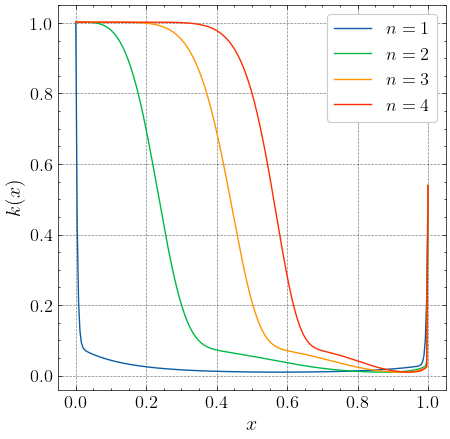

In [17]:
plt.figure(figsize = (5, 5))
plt.xlabel("$x$")
plt.ylabel("$k(x)$")
for e in range(nexp):
    plt.plot(x, conductividad[e], label = f"$n = {e + 1}$")
plt.legend(loc = "best")
plt.savefig("graficas/conductividad_material.pdf", dpi = 300, bbox_inches = "tight")
plt.show()

### Gráfica de la Difusividad Térmica

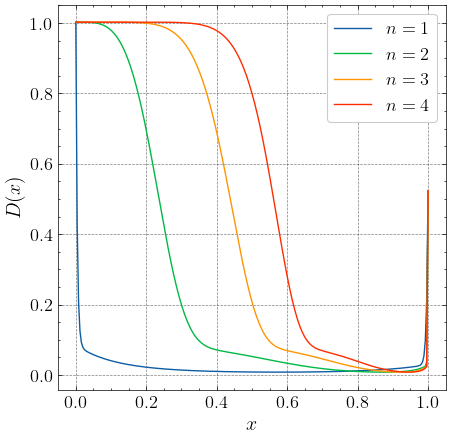

In [18]:
plt.figure(figsize = (5, 5))
plt.xlabel("$x$")
plt.ylabel("$D(x)$")
for e in range(nexp):
    plt.plot(x, difusividad[e], label = f"$n = {e + 1}$")
plt.legend(loc = "best")
plt.savefig("graficas/difusividad_material.pdf", dpi = 300, bbox_inches = "tight")
plt.show()

### Número de Fourier 
Como la conductividad/difusividad térmica adimensional ya está normalizada, se establece el término $D_0 = 1$

Si se quiere que $\alpha = 1$ entonces $t_0 = L^2 \Delta t_0^{-1}$

In [19]:
dif_0 = 1.0
dt_0 = (Lx ** 2) / dif_0
alfa = dif_0 * dt_0 / (Lx**2)
alfa

1.0

### Arreglos del número de Fourier $\alpha$
Los arreglos son del tamaño del dominio espacial, sin embargo, aunque son constantes, los extremos (valores a la frontera) son cero para no modificar las fronteras del problema

In [20]:
valfa = alfa * np.ones(nx + 1)  # Vector/arreglo alfa
valfa[0], valfa[-1] = 0, 0      # Extremos del vector/arreglo alfa

### Arreglos del parametro $\beta$
Los arreglos son del tamaño del dominio espacial, sin embargo, aunque son constantes, los extremos (valores a la frontera) son cero para no modificar las fronteras del problema

In [21]:
vbeta = np.empty((nexp, nx + 1))
for e in range(nexp):
    vbeta[e] = valfa * difusividad[e] * mf.ddx(np.log(densidad[e] * cap_calor[e]), dx)  # Vector/arreglo beta

## Interacción con el ambiente
Para este caso, el sistema es cerrado

In [22]:
interaccion = np.zeros(nx + 1)

### Amplitud de la frontera oscilante
De momento, es constante y no se va a hacer ningún barrido sobre ella

In [23]:
amplitud = 0.1

### Frecuencias de la frontera oscilante
Se genera un arreglo de frecuencias para la frontera oscilante. Los valores precisos de la frecuencia no son importantes sin embargo, si lo es su orden de magnitud, con esta idea, se contruye el arreglo generando valores aleatorios de la frecuencia a partir de valores base

In [24]:
frecuencias = np.loadtxt("datos/frecuencias_linea.csv")
nft = frecuencias.size
nft

721

### Arreglos de datos
Inicialización de los arreglos de los flujos de calor máximos y mínimos. Contiene el mismo número de entradas que el arreglo de frecuencias.

In [25]:
flujocalor_der = np.zeros((nexp, nft))
flujocalor_izq = np.zeros((nexp, nft))

### Iteraciones de la simulación
Calcula los valores máximos y mínimos del flujo de calor para cada frecuencia. Al terminar, cálcula la rectificación térmica

In [26]:
# Barra de progreso
progreso = ipywidgets.FloatProgress(
    value = 0,
    min = 0,
    max = nexp * nft, 
    description = 'Progreso:')
display.display(progreso)

# Proceso de barrido sobre las frecuencias, una por una. Despues se buscara paralelizar este proceso y/o usar cuda para el calculo
progreso.value = 0
for e in range(nexp):
    for f in range(nft):
        series_der_flujocalor, series_izq_flujocalor = simulacion(
            amplitud, frecuencias[f], interaccion, valfa, vbeta[e], difusividad[e], conductividad[e], t, nt, nx, dt, dx)
        
        flujocalor_der[e, f] = integrate.simps(series_der_flujocalor, t) / Lt
        flujocalor_izq[e, f] = integrate.simps(series_izq_flujocalor, t) / Lt
        
        progreso.value = 1 + f + e * nft

FloatProgress(value=0.0, description='Progreso:', max=2884.0)

### Archivos de datos
Archivo .csv de la pareja ordenada del flujo de calor del caso 1 y el flujo de calor del caso 2

In [ ]:
np.savetxt("datos/exponente_linea.csv", exponente)
np.savetxt("datos/flujocalor_izq_linea.csv", flujocalor_izq)
np.savetxt("datos/flujocalor_der_linea.csv", flujocalor_der)